<a href="https://colab.research.google.com/github/PEETA-ANJANA-SREE/Hate-Speech-Detection/blob/main/hate_speech_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
main_data=pd.read_csv("/content/train.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


,label
0,29720
1,2242


0s : 1s  ::   13.26 : 1


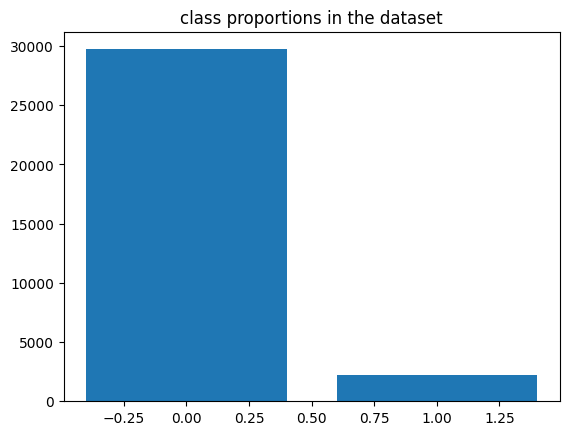

In [ ]:
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

,label
0,29720
1,6726


0s : 1s  ::   4.42 : 1


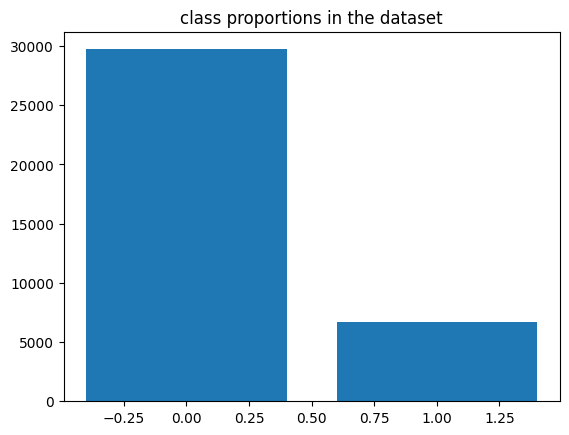

In [ ]:
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))])

    return text2.lower()


In [ ]:
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split()))

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
0    23795
1     5361
Name: label, dtype: int64
29156
===========Test Data =========
0    5925
1    1365
Name: label, dtype: int64
7290


In [ ]:

X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:23324
Class distributionCounter({0: 19035, 1: 4289})
Valid data len:5832
Class distributionCounter({0: 4760, 1: 1072})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:23324
Class distributionCounter({0: 19035, 1: 4289})
Validation data len:5832
Class distributionCounter({0: 4760, 1: 1072})
Test data len:7290
Class distributionCounter({0: 5925, 1: 1365})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[  10  198    6 2501 2318  617  282 1231   10   53  747   48  465    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[2479  730  101  286 1080 1122   45  804    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[ 1262  1045 31270   746    89    49     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))




model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            800016    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
23/23 [==============================] - 13s 339ms/step - loss: 2.9483 - binary_accuracy: 0.8139 - val_loss: 1.5478 - val_binary_accuracy: 0.8162
Epoch 2/10
23/23 [==============================] - 7s 321ms/step - loss: 1.1032 - binary_accuracy: 0.8161 - val_loss: 0.7724 - val_binary_accuracy: 0.8162
Epoch 3/10
23/23 [==============================] - 6s 282ms/step - loss: 0.6864 - binary_accuracy: 0.8161 - val_loss: 0.5637 - val_binary_accuracy: 0.8162
Epoch 4/10
23/23 [==============================] - 8s 340ms/step - loss: 0.5241 - binary_accuracy: 0.8657 - val_loss: 0.4451 - val_binary_accuracy: 0.9174
Epoch 5/10
23/23 [==============================] - 6s 280ms/step - loss: 0.4203 - binary_accuracy: 0.9225 - val_loss: 0.3644 - val_binary_accuracy: 0.9434
Epoch 6/10
23/23 [==============================] - 8s 325ms/step - loss: 0.3398 - binary_accuracy: 0.9464 - val_loss: 0.3053 - val_binary_accuracy: 0.9542
Epoch 7/10
23/23 [==============================] - 10s 464ms/s

In [ ]:
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

183/183 [==============================] - 2s 11ms/step
[[1.89362690e-05]
 [9.91988897e-01]
 [1.78268567e-01]
 [2.12834639e-05]
 [4.00922836e-05]
 [9.76753592e-01]
 [6.11569931e-06]
 [4.10324355e-05]
 [1.52512375e-05]
 [9.49475348e-01]]


In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)



predictions = model.predict(x_test)

228/228 [==============================] - 2s 10ms/step


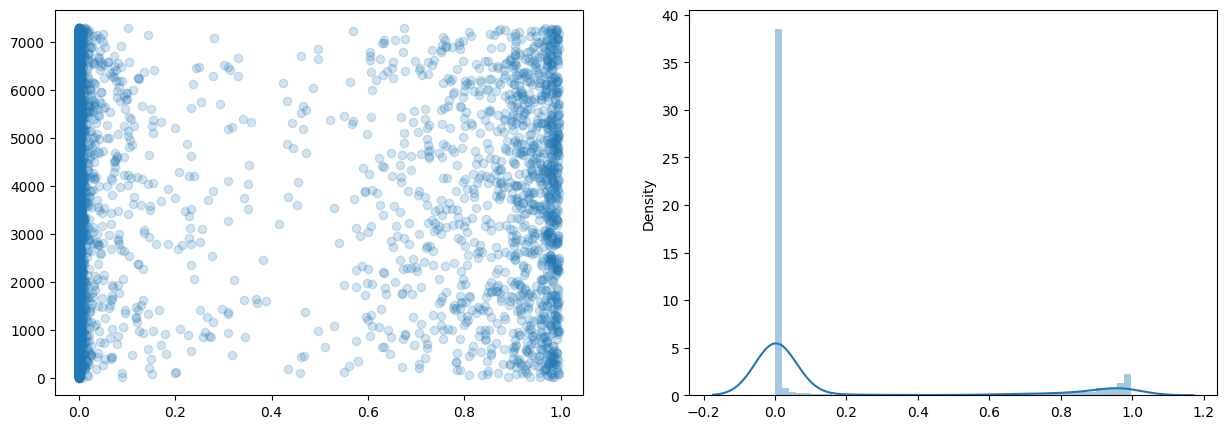

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

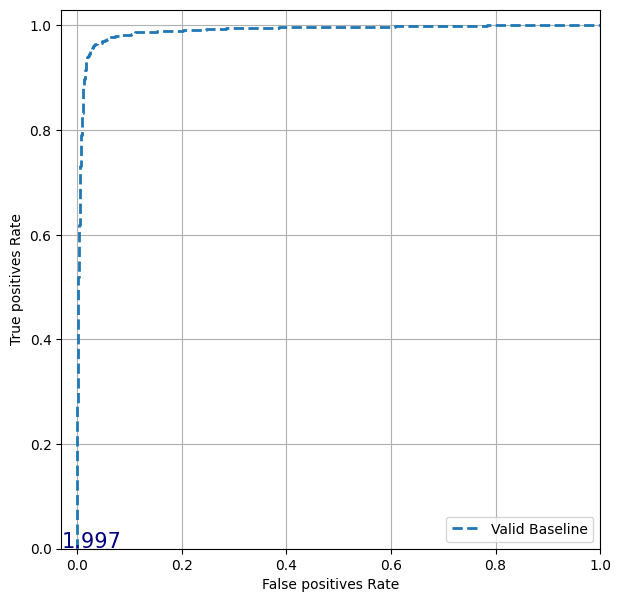

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5925
           1       0.98      0.66      0.79      1365

    accuracy                           0.93      7290
   macro avg       0.96      0.83      0.88      7290
weighted avg       0.94      0.93      0.93      7290



In [ ]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[ 1262,  1045, 31270, ...,     0,     0,     0],
       [  587,    10,   836, ...,     0,     0,     0],
       [    2,  2260,  4132, ...,     0,     0,     0],
       ...,
       [  246,  4234,    73, ...,     0,     0,     0],
       [ 6086,  6087,  1249, ...,     0,     0,     0],
       [  730,     1,    11, ...,     0,     0,     0]], dtype=int32)

array([[13391,     1,  5577, ...,     0,     0,     0],
       [    2,    69, 26519, ...,     0,     0,     0],
       [  604,   732,   759, ...,     0,     0,     0],
       ...,
       [    9,    33,   346, ...,     0,     0,     0],
       [  421,   784,   143, ...,     0,     0,     0],
       [  282,   880,  8138, ...,     0,     0,     0]], dtype=int32)

In [ ]:
predictions = model.predict(f_test)

538/538 [==============================] - 10s 19ms/step


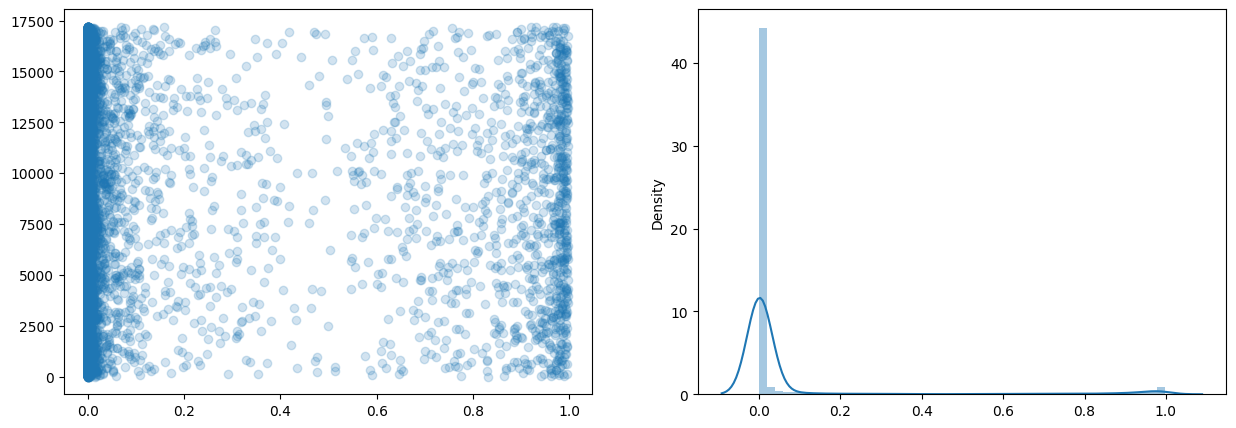

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.2)
ax2=sns.distplot(predictions)

In [ ]:
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
19,thought factory neutrality right wing fascism politics media brexit trump leadership,1.0
26,chick gets fucked hottest naked lady,1.0
33,suppo taiji fisherman bullying racism tweet4taiji thecove seashepherd,1.0
42,user user trumps invested billions into saudi empowers people funding isis trumpsahypocrite,1.0
110,user ivanka bracelet feel good profiting from xenophobia misogyny hatred grabyourwallet,1.0
...,...,...
17128,user governmentâs antisemitism definition conflates with valid criticism israel opendemocracy,1.0
17176,user user most racist ever,1.0
17188,black professor demonizes proposes nazi style confiscation white assets like 1930s germany breaking,1.0
17192,thought factory leftright polarisation trump uselections2016 leadership politics brexit,1.0


In [ ]:
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]


,id,tweet
19,31982,thought factory: bbc neutrality on right wing fascism #politics #media #blm #brexit #trump #leadership &gt;3
26,31989,chick gets fucked hottest naked lady
33,31996,suppo the #taiji fisherman! no bullying! no racism! #tweet4taiji #thecove #seashepherd
42,32005,@user @user trumps invested billions into saudi. he empowers the people funding isis. #trumpsahypocrite
110,32073,hey @user - a $14000 ivanka bracelet? do you feel good profiting from #xenophobia? #misogyny? #hatred? ? #grabyourwallet
...,...,...
17128,49091,@user the uk governmentâs new #anti-semitism definition conflates with valid criticism of #israel | opendemocracy
17176,49139,@user @user are the most racist pay ever!!!!!
17188,49151,"black professor demonizes, proposes nazi style confiscation of ""white"" assets; like 1930's germany #breaking"
17192,49155,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
